In [351]:
import pandas as pd
import ta
from sklearn.preprocessing import MinMaxScaler
import ta.volatility

def get_crypto_prices(cryptos):
    if type(cryptos) != list:
        print("Did not provide a list when trying to get prices")
        return TypeError
    columns = {"ticker":[], "date":[], "open":[], "high":[], "low":[], "close":[]}
    df = pd.DataFrame(data=columns)

    for crypto in cryptos:
            try:
                crypto_price_df = pd.read_csv(f'./crypto_prices/{crypto}.csv')
                df = pd.concat([df, crypto_price_df], ignore_index=True)
            except FileNotFoundError as e:
                print(f"Could not find file {crypto}") 


    # Adds derived fields using Technical Analylsis Library
    df['MA_10'] = df['close'].rolling(window=10).mean()
    df['MA_50'] = df['close'].rolling(window=50).mean()
    df['RSI'] = ta.momentum.RSIIndicator(df['close'], window=14).rsi()
    df['MACD'] = ta.trend.MACD(df['close']).macd()
    df['MACD_signal'] = ta.trend.MACD(df['close']).macd_signal()
    df['ADX_Indicator'] = ta.trend.ADXIndicator(df['high'],df['low'],df['close'],14).adx()

    indicator_bb = ta.volatility.BollingerBands(close=df["close"], window=20, window_dev=2)
    # Add Bollinger Band high indicator
    df['bb_bbhi'] = indicator_bb.bollinger_hband_indicator()

    # Add Bollinger Band low indicator
    df['bb_bbli'] = indicator_bb.bollinger_lband_indicator()

    # 2. Calculate 3d, 7d, 1M, 3M and 6M Rolling low and highs
    windows = {
         '3D': 3,
         '7D': 7,
         '1M': 30,
         '3M': 90,
         '6M': 180
    }
    for key, window in windows.items():
         df[f'Roll_Low_{key}'] = df['close'].rolling(window=window).min()
         df[f'Roll_High_{key}'] = df['close'].rolling(window=window).max()

    df['3dUpTrend'] = (df['close'] >= df['Roll_High_3D']).astype(int)
    df['6mUpTrend'] = (df['close'] >= df['Roll_High_6M']).astype(int) 

    # 3. Handle missing values - specifically MA
    df.fillna(method="bfill", inplace=True)
    df.fillna(method="ffill", inplace=True)
    
    # Set the 'date' column as the index
    df['date'] = pd.to_datetime(df['date'])
    df.set_index("date", inplace=True)

    # # 4. Normalise data
    # # Select features for normalization
    features = ['high','open','close','bb_bbm', 'bb_bbh', 'bb_bbl','bb_bbhi','bb_bbli','RSI', 'MACD', 'MACD_signal', 'MACD_diff', "Roll_Low_3D","Roll_Low_7D","Roll_Low_1M","Roll_Low_3M","Roll_Low_6M","Roll_High_3D","Roll_High_7D","Roll_High_1M","Roll_High_3M","Roll_High_6M"]
    features = ['close','bb_bbhi','bb_bbli','RSI', 'MACD_signal',"ADX_Indicator", '3dUpTrend', '6mUpTrend']
    features = ['close','RSI', 'MACD_signal',"ADX_Indicator", '3dUpTrend', '6mUpTrend']

    # # Normalize the features
    scaler = MinMaxScaler()
    scaled_features = scaler.fit_transform(df[features])

    # Convert to DataFrame
    scaled_df = pd.DataFrame(scaled_features, columns=features, index=df.index)
    return scaled_df

In [352]:
import ast
def get_crypto_news(cryptos):
    if type(cryptos) != list:
        print("Did not provide a list when trying to get prices")
        return TypeError

    df = pd.read_csv(f'./crypto_news/cryptonews.csv')
    df['date'] = df["date"].str[:10].str.strip()
    df['date'] = pd.to_datetime(df['date'])
    df.set_index("date", inplace=True)
    return df


Feature Selection
- Correlation Matrix
- Feature Importance

In [353]:
price_df = get_crypto_prices(["BTC"])

news_df = get_crypto_news(["BTC"])

# Only bitcoin news
news_df = news_df[news_df["subject"] == "bitcoin"] 
# news_df

# get sentiment dic
news_df["sentiment_dic"] = news_df['sentiment'].apply(ast.literal_eval)
news_df["sentiment_dic"]
news_df[['class','polarity','subjectivity']] = news_df['sentiment_dic'].apply(pd.Series)
news_df.drop(columns=["sentiment_dic", "sentiment", "source", "text", "url", "title", "subject"],inplace=True)

df = pd.merge(price_df, news_df, on="date", how="left")
df['class'] = df['class'].fillna("neutral")
df['polarity'] = df['polarity'].fillna(0)
df['subjectivity'] = df['subjectivity'].fillna(0)
class_mapping = {
    "negative": -1,
    "neutral": 0,
    "positive": 1
}
df['class'] = df['class'].map(class_mapping)
df

/var/folders/px/twgpqgld6kv3v02mv85cchhh0000gn/T/ipykernel_5102/1691680110.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
/var/folders/px/twgpqgld6kv3v02mv85cchhh0000gn/T/ipykernel_5102/1691680110.py:53: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="ffill", inplace=True)


,close,RSI,MACD_signal,ADX_Indicator,3dUpTrend,6mUpTrend,class,polarity,subjectivity
date,,,,,,,,,
2010-07-17,0.000000e+00,0.495753,0.468923,0.000000,0.0,0.0,0,0.0,0.0
2010-07-18,4.977561e-07,0.495753,0.468923,0.000000,0.0,0.0,0,0.0,0.0
2010-07-19,4.287032e-07,0.495753,0.468923,0.000000,0.0,0.0,0,0.0,0.0
2010-07-20,3.456754e-07,0.495753,0.468923,0.000000,0.0,0.0,0,0.0,0.0
2010-07-21,4.069187e-07,0.495753,0.468923,0.000000,0.0,0.0,0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
2024-07-16,8.839323e-01,0.599756,0.307939,0.470849,1.0,0.0,0,0.0,0.0
2024-07-17,8.812976e-01,0.590240,0.335084,0.450783,0.0,0.0,0,0.0,0.0
2024-07-18,8.746307e-01,0.565530,0.361928,0.427659,0.0,0.0,0,0.0,0.0


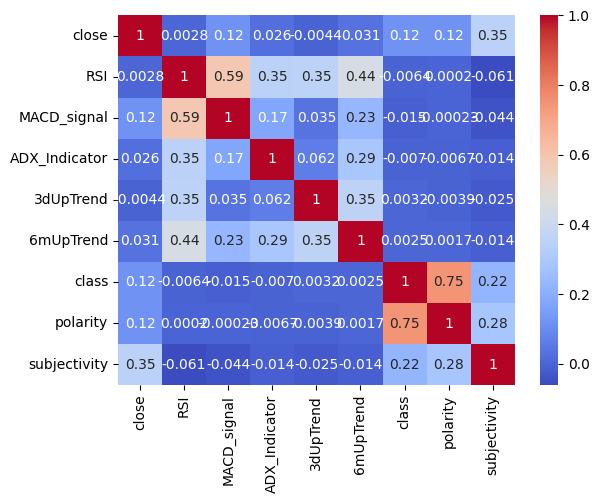

In [354]:
import seaborn as sns
import matplotlib.pyplot as plt

# Correlation matrix
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

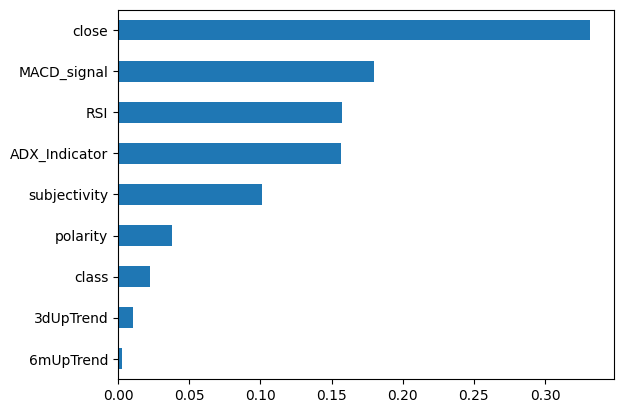

In [355]:
# Feature importance using Random Forest
from sklearn.ensemble import RandomForestClassifier
X = df.iloc[:-1,:]  # Assuming 'Close' is the target
y = (df['close'].shift(-1) > df['close']).astype(int)  # Binary classification: 1 if price increases, 0 otherwise
model = RandomForestClassifier()
model.fit(X, y[:-1])

importances = model.feature_importances_
feature_importance = pd.Series(importances, index=X.columns)
feature_importance.sort_values().plot(kind='barh')
plt.show()


In [37]:
# # Select features with importance greater than a threshold
# threshold = 0.05
# important_features = feature_importance[feature_importance > threshold].index

# # Create a new DataFrame with only important features
# X_important = X[important_features]

# # Re-train the model with important features only
# model.fit(X_important, y)

# # Evaluate the model
# y_pred = model.predict(X_important)
# from sklearn.metrics import classification_report
# print(classification_report(y, y_pred))

Assuming that there has not been features removed AND we do not currently have included sentiment analysis

In [356]:
# Creating Sequences for LSTM
import numpy as np
def create_sequences(data, window_size=60):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size])
    return np.array(X), np.array(y)

window_size = 60  # Example window size
X, y = create_sequences(df.values, window_size)
y = (df['close'].shift(-1) > df['close']).astype(int)[window_size:]  # Target variable

In [357]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Model Creation and Training

# Split the data into training and testing sets
split = int(0.8 * len(X))  # 80-20 split for training and testing
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Build and train the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))  # Binary classification

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=4, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/4


/Users/moises/Desktop/price_prediction/env/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


357/357 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.7893 - loss: 0.4021 - val_accuracy: 0.9278 - val_loss: 0.2050
Epoch 2/4
357/357 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.8094 - loss: 0.3506 - val_accuracy: 0.9299 - val_loss: 0.2095
Epoch 3/4
357/357 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.8042 - loss: 0.3538 - val_accuracy: 0.9299 - val_loss: 0.2046
Epoch 4/4
357/357 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.8037 - loss: 0.3562 - val_accuracy: 0.9313 - val_loss: 0.1989


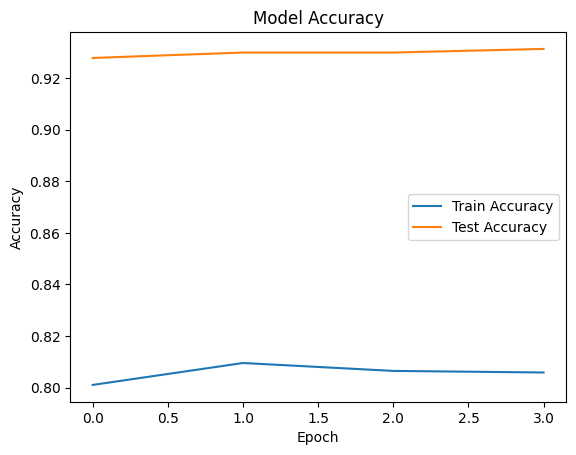

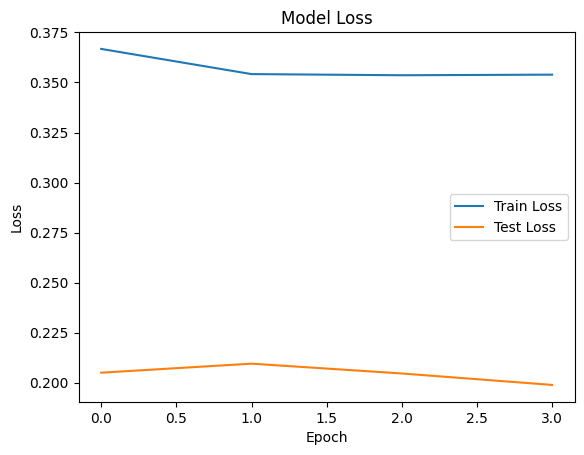

In [358]:
# Model Evaluation and Prediction
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()


In [359]:
# Make predictions
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)

# Convert predictions and true values back to their original scales if needed
# For example, if y_test was scaled, apply inverse scaling

from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))


90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
              precision    recall  f1-score   support

           0       0.94      0.99      0.96      2649
           1       0.61      0.12      0.20       205

    accuracy                           0.93      2854
   macro avg       0.77      0.56      0.58      2854
weighted avg       0.91      0.93      0.91      2854



Plot results

date
2023-06-26    0.413281
2023-06-26    0.413281
2023-06-26    0.413281
2023-06-26    0.413281
2023-06-26    0.413281
                ...   
2024-07-06    0.792872
2024-07-09    0.791899
2024-07-16    0.883932
2024-07-17    0.881298
2024-07-20    0.919616
Name: close, Length: 47091, dtype: float64


ValueError: x and y must be the same size

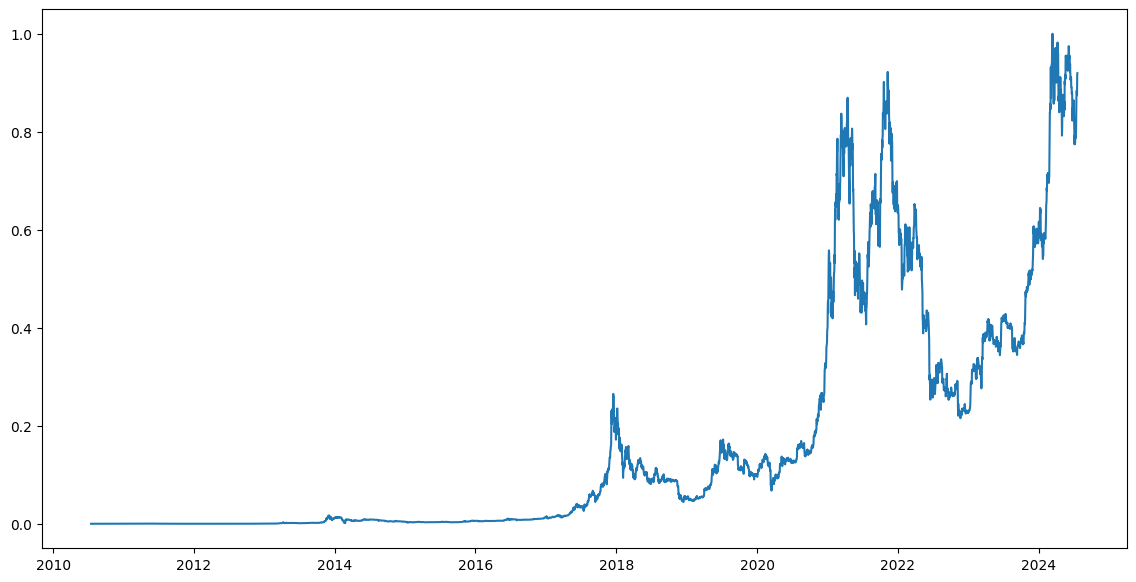

In [360]:
# Convert predictions and actual values to DataFrame
results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred.flatten()})

# Plot BTC price
plt.figure(figsize=(14,7))
plt.plot(df['close'], label='BTC Price')


# Mark correct predictions
correct_predictions = results[results['Actual'] == results['Predicted']]
print(df.loc[correct_predictions.index]['close'])
plt.scatter(correct_predictions.index, df.loc[correct_predictions.index]['close'], color='green', label='Correct Predictions', marker='o')

# # Mark incorrect predictions
# incorrect_predictions = results[results['Actual'] != results['Predicted']]
# plt.scatter(incorrect_predictions.index, df.iloc[incorrect_predictions.index]['close'], color='red', label='Incorrect Predictions', marker='x')

plt.title('BTC Price with Predictions')
plt.xlabel('Time')
plt.ylabel('BTC Price')
plt.legend()
plt.show()
